In [1]:
# Libraries

import os
import cv2
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Flatten, Dense, Conv2DTranspose, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split

import dotenv


2024-11-20 18:05:26.411055: E external/local_xla/xla/stream_executor/plugin_registry.cc:93] Invalid plugin kind specified: DNN


### Hyperparameters

In [2]:
# Load environment variables
dotenv.load_dotenv()

EPOCHS = 50
BATCH_SIZE = 128
IMAGE_SIZE = 128 
NUM_CLASSES = 4


### Import Dataset

In [3]:
training_dataset_path = os.path.join(os.environ['DATASET_PATH'], 'Training')

class_labels = {'glioma': 0, 'meningioma': 1, 'pituitary': 2, 'notumor': 3}
image_folders = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_labels_reverse = {v: k for k, v in class_labels.items()}

In [4]:
# Load images and masks
images = []
masks = []
class_labels_list = []

for folder in image_folders:
    folder_path = os.path.join(training_dataset_path, folder)
    image_files = sorted(os.listdir(folder_path))

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))

        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE), dtype=np.uint8)
        if folder == 'glioma':
            mask[50:100, 50:100] = 1
        elif folder == 'meningioma':
            mask[30:80, 30:80] = 1
        elif folder == 'pituitary':
            mask[40:90, 40:90] = 1
        elif folder == 'notumor':
            mask[:, :] = 0

        images.append(img)
        masks.append(mask)
        class_labels_list.append(class_labels[folder])

# Convert lists to numpy arrays
images = np.array(images).astype('float32') / 255.0
masks = np.array(masks).astype('float32')

# Expand dimensions to match model requirements
images = np.expand_dims(images, axis=-1)
images_rgb = np.repeat(images, 3, axis=-1)
masks = np.expand_dims(masks, axis=-1)

# Convert class labels to categorical
class_labels_list = to_categorical(class_labels_list, num_classes=NUM_CLASSES)

# Split dataset into training and validation sets
X_train, X_val, y_train_seg, y_val_seg, y_class_train, y_class_val = train_test_split(
    images_rgb, masks, class_labels_list, test_size=0.2, random_state=42
)

In [5]:
def unet_with_resnet_backbone(input_size=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=4):
    inputs = Input(input_size)
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    # Encoder using ResNet50 layers
    c1 = resnet_base.get_layer('conv1_relu').output
    c2 = resnet_base.get_layer('conv2_block3_out').output
    c3 = resnet_base.get_layer('conv3_block4_out').output
    c4 = resnet_base.get_layer('conv4_block6_out').output
    c5 = resnet_base.get_layer('conv5_block3_out').output

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder - Adjust strides to ensure output matches (128, 128, 1)
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)

    # Add another transpose convolution layer to upscale to (128, 128)
    u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
    c10 = Conv2D(32, (3, 3), activation='relu', padding='same')(u10)

    # Segmentation output (binary output for tumor or not-tumor)
    segmentation_output = Conv2D(1, (1, 1), activation='sigmoid', name='segmentation_output')(c10)

    # Classification head
    classification = GlobalAveragePooling2D()(c5)
    dense1 = Dense(512, activation='relu')(classification)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(256, activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(dense2)
    classification_output = Dense(num_classes, activation='softmax', name='classification_output')(dropout2)

    # Create a model with both outputs
    model = Model(inputs=[inputs], outputs=[segmentation_output, classification_output])
    return model

In [7]:
# Create the combined model
model = unet_with_resnet_backbone()

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={'segmentation_output': 'binary_crossentropy', 'classification_output': 'categorical_crossentropy'},
    metrics={'segmentation_output': ['accuracy'], 'classification_output': ['accuracy']}
)

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [8]:
# Train the combined model
history = model.fit(
    X_train,
    {'segmentation_output': y_train_seg, 'classification_output': y_class_train},
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, {'segmentation_output': y_val_seg, 'classification_output': y_class_val})
)

Epoch 1/50


I0000 00:00:1732144011.796835   90872 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


36/36 [==============================] - 150s 2s/step - loss: 0.9531 - segmentation_output_loss: 0.3623 - classification_output_loss: 0.5907 - segmentation_output_accuracy: 0.8608 - classification_output_accuracy: 0.7781 - val_loss: 2.4209 - val_segmentation_output_loss: 0.6386 - val_classification_output_loss: 1.7823 - val_segmentation_output_accuracy: 0.8863 - val_classification_output_accuracy: 0.2520
Epoch 2/50
36/36 [==============================] - 35s 961ms/step - loss: 0.2318 - segmentation_output_loss: 0.1231 - classification_output_loss: 0.1087 - segmentation_output_accuracy: 0.9419 - classification_output_accuracy: 0.9641 - val_loss: 2.8727 - val_segmentation_output_loss: 0.8331 - val_classification_output_loss: 2.0396 - val_segmentation_output_accuracy: 0.8863 - val_classification_output_accuracy: 0.2520
Epoch 3/50
36/36 [==============================] - 35s 962ms/step - loss: 0.0810 - segmentation_output_loss: 0.0446 - classification_output_loss: 0.0364 - segmentation_ou

In [9]:
# Save Model Output
model.save('segmentation2_model.h5')

# Save the model history to a file
with open('segmentation2_training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

/home/romit/.local/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


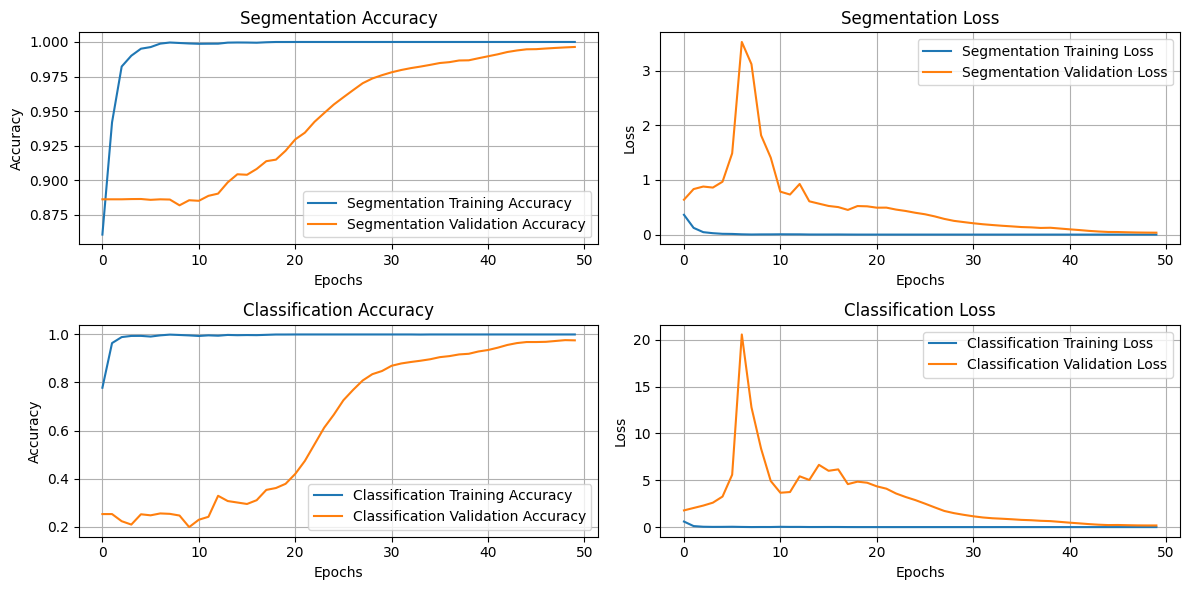

NameError: name 'y_val' is not defined

In [ ]:
plt.figure(figsize=(12, 6))

#Training and Validation Accuracy for Segmentation
plt.subplot(2, 2, 1)
plt.plot(history.history['segmentation_output_accuracy'], label='Segmentation Training Accuracy')
plt.plot(history.history['val_segmentation_output_accuracy'], label='Segmentation Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Segmentation Accuracy')
plt.legend()
plt.grid(True)

#Training and Validation Loss for Segmentation
plt.subplot(2, 2, 2)
plt.plot(history.history['segmentation_output_loss'], label='Segmentation Training Loss')
plt.plot(history.history['val_segmentation_output_loss'], label='Segmentation Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Segmentation Loss')
plt.legend()
plt.grid(True)

#Training and Validation Accuracy for Classification
plt.subplot(2, 2, 3)
plt.plot(history.history['classification_output_accuracy'], label='Classification Training Accuracy')
plt.plot(history.history['val_classification_output_accuracy'], label='Classification Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy')
plt.legend()
plt.grid(True)

#Training and Validation Loss for Classification
plt.subplot(2, 2, 4)
plt.plot(history.history['classification_output_loss'], label='Classification Training Loss')
plt.plot(history.history['val_classification_output_loss'], label='Classification Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Classification Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate the model on the validation (split) set
val_results = model.evaluate(X_val, {'segmentation_output': y_val_seg, 'classification_output': y_class_val})

print(f"Validation Loss: {val_results[0]}")
print(f"Segmentation Loss: {val_results[1]}, Segmentation Accuracy: {val_results[3]}")
print(f"Classification Loss: {val_results[2]}, Classification Accuracy: {val_results[4]}")


In [ ]:
def test_image_with_segmentation_and_classification(model, image_path):
    # Load and preprocess the input image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to match training input size
    img = img.astype('float32') / 255.0  # Normalize
    img = np.repeat(img, 3, axis=-1)  # Convert grayscale to RGB
    img = img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3)  # Add batch dimension
    
    # Predict the segmentation mask and class label
    segmentation_pred, classification_pred = model.predict(img)
    
    # Convert the segmentation prediction to binary (threshold)
    predicted_mask = (segmentation_pred > 0.5).astype(np.uint8)  # Threshold the output to get binary mask
    
    # Get the class index with the highest probability
    predicted_class = np.argmax(classification_pred, axis=1)
    predicted_label = class_labels_reverse[predicted_class[0]]  # Map the class index to label

    # Plot the input image, predicted mask, and classification label
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img[0, :, :, 0], cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask[0, :, :, 0], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.text(0.5, 0.5, f'Predicted Class: {predicted_label}', fontsize=12, ha='center')
    plt.axis('off')
    plt.title('Classification Result')

    plt.tight_layout()
    plt.show()

# Test the model on a sample image
test_image_path = os.path.join(os.environ['DATASET_PATH'], 'Testing/glioma/Te-gl_0010.jpg')
test_image_with_segmentation_and_classification(model, test_image_path)

# Load the testing dataset
testing_dataset_path = os.path.join(os.environ['DATASET_PATH'], 'Testing')

test_images = []
test_labels = []

# Loop over the folders in the Testing dataset to load images and their labels
for folder in image_folders:
    folder_path = os.path.join(testing_dataset_path, folder)
    
    # List image files in the folder
    image_files = sorted(os.listdir(folder_path))

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)

        # Read the image (grayscale because MRI data)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Resize image if necessary (standardize image size)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))

        # Append image and label (use list append method)
        test_images.append(img)
        test_labels.append(class_labels[folder])  # Assign label based on folder name

# Convert lists to numpy arrays after appending all images and labels
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Normalize the test images
test_images = test_images.astype('float32') / 255.0

# Convert images to 3 channels (grayscale to RGB) for ResNet50
test_X_rgb = np.repeat(test_images.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1), 3, axis=-1)

# Convert classification labels to one-hot encoding
test_labels_class = to_categorical(test_labels, num_classes=len(class_labels))

# Dummy masks for testing (in a real scenario, you would load actual masks)
test_labels_seg = np.zeros((len(test_images), IMAGE_SIZE, IMAGE_SIZE, 1), dtype=np.float32)

# Evaluate the model on the testing set
test_loss, test_seg_loss, test_class_loss, test_seg_acc, test_class_acc = model.evaluate(
    test_X_rgb,
    {'segmentation_output': test_labels_seg, 'classification_output': test_labels_class}
)
print(f"Testing Loss: {test_loss}")
print(f"Segmentation Loss: {test_seg_loss}, Segmentation Accuracy: {test_seg_acc}")
print(f"Classification Loss: {test_class_loss}, Classification Accuracy: {test_class_acc}")

# Generate predictions for the test dataset
segmentation_preds, classification_preds = model.predict(test_X_rgb)

# Convert predictions to classes
predicted_classes = np.argmax(classification_preds, axis=1)

# Compute the confusion matrix for classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(test_labels, predicted_classes, labels=range(len(class_labels)))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(class_labels.values()))
disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')

plt.title("Confusion Matrix for Classification")
plt.show()



1/1 [==============================] - 1s 819ms/step


TypeError: '>' not supported between instances of 'list' and 'float'